In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Đường dẫn đến các tập dữ liệu
usd_data_path = '/content/drive/MyDrive/dataset/US Dollar Index Futures Historical Data.csv'
bitcoin_data_path = '/content/drive/MyDrive/dataset/Bitcoin Historical Data.csv'
nasdaq_data_path = '/content/drive/MyDrive/dataset/NASDAQ Composite Historical Data.csv'

In [28]:
# Define a function to preprocess each dataset
def preprocess_data(data_path, date_format='%d/%m/%Y'):
  df = pd.read_csv(data_path)
  df = df[::-1] # Reverse the order
  df.fillna(method='ffill', inplace=True)
  df['Price'] = df['Price'].str.replace(',', '').astype(float)
  df['Date'] = pd.to_datetime(df['Date'], format=date_format)
  return df

In [29]:
# Define a function to preprocess each dataset
def preprocess_us_data(data_path, date_format='%m/%d/%Y'):
    df = pd.read_csv(data_path)
    df = df[::-1]  # Reverse the order
    df.fillna(method='ffill', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    return df

In [30]:
# Preprocess each dataset
bitcoin_df = preprocess_data(bitcoin_data_path)
nasdaq_df = preprocess_data(nasdaq_data_path)
usd_df = preprocess_us_data(usd_data_path)

print(bitcoin_df)
print(nasdaq_df)
print(usd_df)

           Date    Price       Open       High        Low    Vol. Change %
4110 2013-03-01     34.5       33.4       34.9       32.9  39.79K    3.36%
4109 2013-03-02     34.3       34.5       34.8       33.2  36.66K   -0.72%
4108 2013-03-03     34.5       34.3       34.5       33.8  12.53K    0.73%
4107 2013-03-04     36.2       34.5       36.7       34.2  46.77K    4.78%
4106 2013-03-05     40.3       36.2       40.7       36.2  85.43K   11.56%
...         ...      ...        ...        ...        ...     ...      ...
4    2024-05-28  68366.0  69,428.30  69,560.70  67,299.90  71.39K   -1.53%
3    2024-05-29  67635.8  68,366.20  68,897.60  67,143.20  52.13K   -1.07%
2    2024-05-30  68354.7  67,631.30  69,504.70  67,138.40  66.84K    1.06%
1    2024-05-31  67530.1  68,352.30  69,018.20  66,676.80  61.51K   -1.21%
0    2024-06-01  67760.8  67,533.90  67,861.00  67,449.60  19.01K    0.34%

[4111 rows x 7 columns]
           Date     Price       Open       High        Low     Vol. Change 

# DATASET BITCOIN

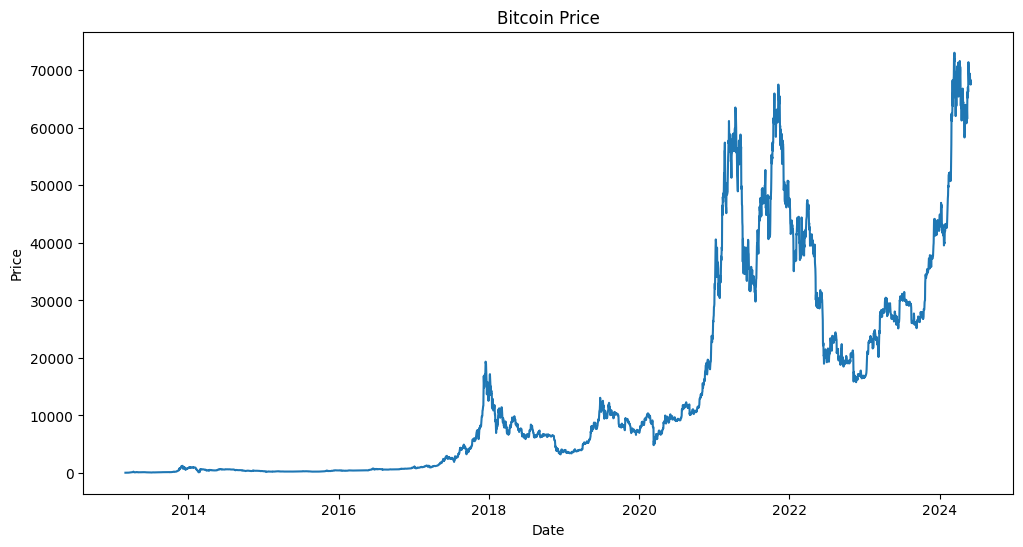

In [31]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['Price'])
plt.title('Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# DATASET NASDAQ


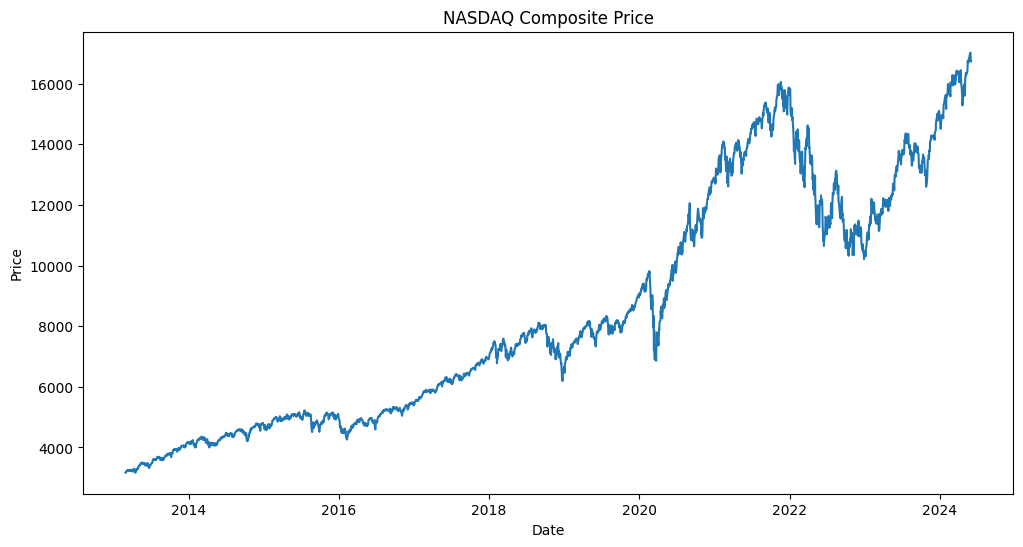

In [32]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(nasdaq_df['Date'], nasdaq_df['Price'])
plt.title('NASDAQ Composite Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# DATASET US Dollar Index

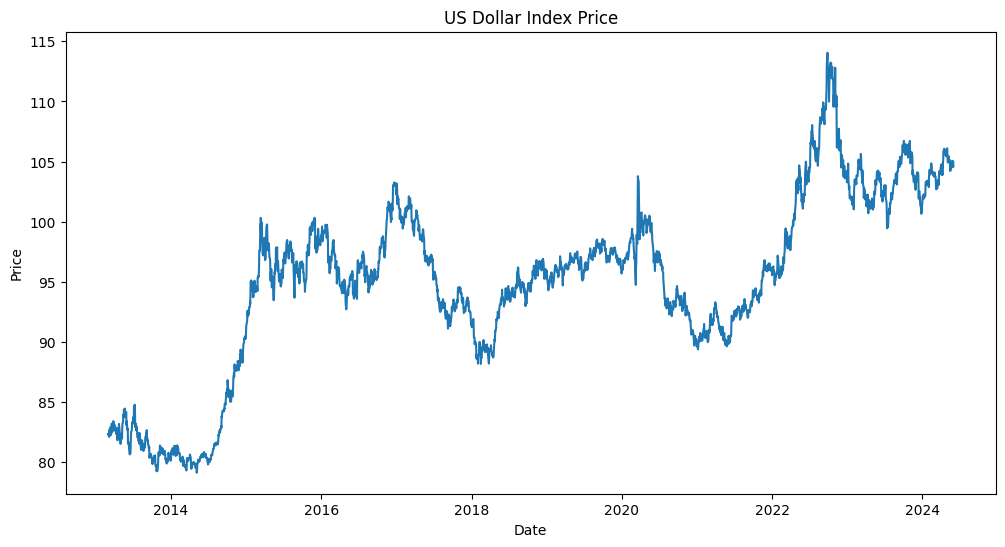

In [33]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(usd_df['Date'], usd_df['Price'])
plt.title('US Dollar Index Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [34]:
# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []

    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
        print(np.array(xs), np.array(ys))
    return np.array(xs), np.array(ys)

In [35]:
# Function to forecast future prices
def forecast_future(model, data, steps, scaler, sequence_length=30):
    last_sequence = data[-sequence_length:].reshape(1, sequence_length, 1)
    forecast = []
    for _ in range(steps):
        prediction = model.predict(last_sequence)
        forecast.append(prediction[0, 0])
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1, 0] = prediction[0, 0]
        print(last_sequence)

    forecast = np.array(forecast).reshape(-1, 1)
    forecast_prices = scaler.inverse_transform(forecast)
    print(forecast_prices)
    return forecast_prices.flatten()

In [36]:
# Function to split data into training and testing sets
def split_data(X, y, ratio):
    train_size = int(len(X) * ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

In [37]:
# Function to build the LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    return model

In [38]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.2f}%')
    print(f'RMSE: {rmse:.4f}')
    return mae, mape, rmse

In [39]:
# Function to process the dataset and plot the results
def process_dataset(df, dataset_name, sequence_length=30, split_ratio=0.8):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Price']].values)
    X, y = create_sequences(scaled_data, sequence_length)
    X_train, X_test, y_train, y_test = split_data(X, y, split_ratio)

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(input_shape)
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1)

    # Predictions
    predicted_prices = model.predict(X_test)

    # Inverse transform to get actual prices
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    predicted_prices_actual = scaler.inverse_transform(predicted_prices).flatten()

    # Evaluation
    mae, mape, rmse = evaluate_model(actual_prices, predicted_prices_actual)

    # Forecast future prices
    future_steps = 30
    future_forecast_1 = forecast_future(model, scaled_data, future_steps, scaler)
    future_forecast_2 = forecast_future(model, scaler.transform(future_forecast_1.reshape(-1, 1)), future_steps, scaler)
    future_forecast_3 = forecast_future(model, scaler.transform(future_forecast_2.reshape(-1, 1)), future_steps, scaler)

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Price'], color='blue', label='Training Data', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], actual_prices, color='orange', label='Actual Price', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], predicted_prices_actual, color='green', label='Predicted Price', linestyle='solid')

    future_dates_1 = pd.date_range(df['Date'].iloc[-1], periods=future_steps + 1)[1:]
    future_dates_2 = pd.date_range(future_dates_1[-1], periods=future_steps + 1)[1:]
    future_dates_3 = pd.date_range(future_dates_2[-1], periods=future_steps + 1)[1:]

    plt.plot(future_dates_1, future_forecast_1, color='red', label='Next 30 Days Forecast', linestyle='solid')
    plt.plot(future_dates_2, future_forecast_2, color='yellow', label='Next 60 Days Forecast', linestyle='solid')
    plt.plot(future_dates_3, future_forecast_3, color='brown', label='Next 90 Days Forecast', linestyle='solid')

    plt.title(f'LSTM {dataset_name} Time Series Forecast Ratio {round(split_ratio * 10)}:{round((1 - split_ratio) * 10)}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {'mae': mae, 'rmse': rmse, 'mape': mape}

# BITCOIN

# RATIO 6:4

Streaming output truncated to the last 5000 lines.
 [0.00082293]
 [0.00088454]
 [0.0008599 ]
 [0.00087907]
 [0.00076405]
 [0.00079006]
 [0.00075994]
 [0.00079006]
 [0.00078459]
 [0.00083936]
 [0.00083251]
 [0.00085716]
 [0.00084484]
 [0.00082293]
 [0.00088317]
 [0.00092014]
 [0.00100915]
 [0.0009845 ]
 [0.00095438]
 [0.00096122]
 [0.0009667 ]
 [0.00096944]
 [0.00099135]
 [0.00098998]
 [0.00098176]
 [0.00094205]
 [0.00093795]
 [0.00094068]
 [0.00096807]
 [0.00099272]
 [0.00103105]
 [0.00107213]
 [0.00103653]
 [0.00102284]
 [0.00107487]
 [0.00108309]
 [0.00115292]
 [0.00118989]
 [0.00121864]
 [0.00120084]
 [0.00115292]
 [0.00116798]
 [0.00120221]
 [0.00117483]
 [0.00132818]
 [0.00129395]
 [0.0013008 ]
 [0.00141993]
 [0.001461  ]
 [0.00152947]
 [0.00150208]
 [0.00150208]
 [0.00134462]
 [0.00131312]
 [0.00119947]
 [0.00129669]
 [0.00125972]
 [0.00135283]
 [0.00134599]
 [0.00147607]
 [0.0014391 ]
 [0.0014569 ]
 [0.00140213]
 [0.00142403]
 [0.0014391 ]
 [0.00143499]
 [0.00145279]
 [0.0013802

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 [0.01027906]
 [0.01055017]
 [0.01056523]
 [0.01070216]
 [0.01126356]
 [0.01163873]
 [0.01219192]
 [0.01342425]
 [0.01339687]
 [0.01157849]
 [0.01238498]
 [0.01236034]
 [0.01264514]
 [0.01329554]
 [0.01239867]
 [0.01216727]
 [0.01211798]
 [0.01241784]
 [0.01203856]
 [0.01177429]
 [0.01193176]
 [0.01260406]
 [0.0126205 ]
 [0.01270539]
 [0.01255203]
 [0.01245892]
 [0.01207964]
 [0.01268896]
 [0.01331882]
 [0.01244934]
 [0.01230146]
 [0.01220561]
 [0.01242058]
 [0.01238498]
 [0.01240689]
 [0.01258353]
 [0.01228776]
 [0.01221793]
 [0.01191532]
 [0.01088016]
 [0.0090563 ]
 [0.00841412]
 [0.008562  ]
 [0.00750767]
 [0.00745837]
 [0.0068025 ]
 [0.0057112 ]
 [0.00538668]
 [0.00461168]
 [0.00363539]
 [0.00325885]
 [0.00355598]
 [0.00311097]
 [0.00106255]
 [0.00105844]
 [0.00303018]
 [0.0037778 ]
 [0.00191286]
 [0.0013898 ]
 [0.00765144]
 [0.007698  ]
 [0.00738854]
 [0.00716261]
 [0.00698735]
 [0.0085976 ]
 [0.00859212]
 [0.0085442 ]
 [0.0084072

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  [2.73852558e-06]
  [2.60159930e-05]
  ...
  [7.69525687e-04]
  [7.92803155e-04]
  [8.03757257e-04]]

 [[2.73852558e-06]
  [2.60159930e-05]
  [8.21557673e-05]
  ...
  [7.92803155e-04]
  [8.03757257e-04]
  [9.54376164e-04]]

 ...

 [[9.50379286e-01]
  [9.68449447e-01]
  [9.56257531e-01]
  ...
  [9.08926224e-01]
  [8.79770512e-01]
  [8.82665133e-01]]

 [[9.68449447e-01]
  [9.56257531e-01]
  [9.52694709e-01]
  ...
  [8.79770512e-01]
  [8.82665133e-01]
  [8.72659930e-01]]

 [[9.56257531e-01]
  [9.52694709e-01]
  [9.76252875e-01]
  ...
  [8.82665133e-01]
  [8.72659930e-01]
  [8.68420692e-01]]] [[8.03757257e-04]
 [9.54376164e-04]
 [1.14607295e-03]
 ...
 [8.72659930e-01]
 [8.68420692e-01]
 [8.63667981e-01]]
[[[2.73852558e-06]
  [0.00000000e+00]
  [2.73852558e-06]
  ...
  [7.10647387e-04]
  [7.69525687e-04]
  [7.92803155e-04]]

 [[0.00000000e+00]
  [2.73852558e-06]
  [2.60159930e-05]
  ...
  [7.69525687e-04]
  [7.92803155e-04]
  [8.03757257e-

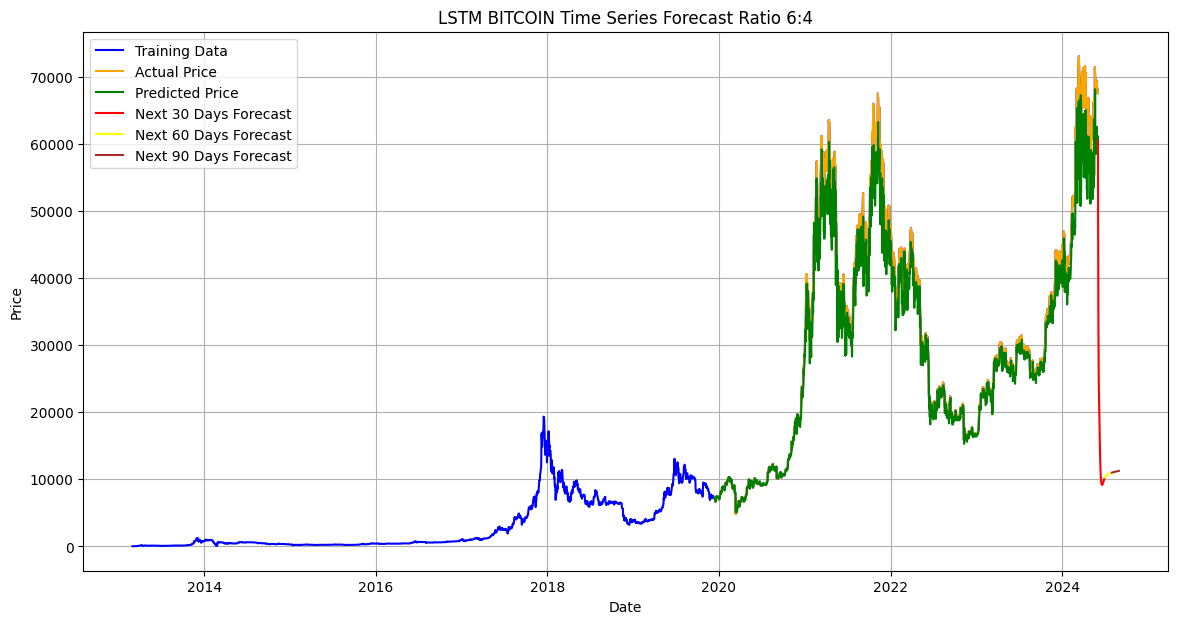

Testing MAE: 1956.5202
Testing RMSE: 3165.1728
Testing MAPE: 4.78%


In [40]:
results = process_dataset(bitcoin_df, "BITCOIN", 30, 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Streaming output truncated to the last 5000 lines.
 [0.00108035]
 [0.00107487]
 [0.00114197]
 [0.00111321]
 [0.00110226]
 [0.00114607]
 [0.0010557 ]
 [0.00109404]
 [0.00114881]
 [0.00122138]
 [0.00121727]
 [0.00120769]
 [0.00120084]
 [0.00121317]
 [0.00122549]
 [0.00125972]
 [0.00135283]
 [0.00133777]
 [0.00135831]
 [0.00130765]
 [0.00129669]
 [0.00134188]
 [0.00129395]
 [0.00129395]
 [0.0013008 ]
 [0.00120769]
 [0.00118304]
 [0.00119263]
 [0.00119947]
 [0.00115977]
 [0.00105022]
 [0.00100778]
 [0.00090508]
 [0.00098587]
 [0.00102284]
 [0.0010201 ]
 [0.00095301]
 [0.00089961]
 [0.00089687]
 [0.00089824]
 [0.00092562]
 [0.00099956]
 [0.00101325]
 [0.00105433]
 [0.00102969]
 [0.00101189]
 [0.00100778]
 [0.00092836]
 [0.00094479]
 [0.00095438]
 [0.00092288]
 [0.00082703]
 [0.00083114]
 [0.00086537]
 [0.00073666]
 [0.00076816]
 [0.00061069]
 [0.00062575]
 [0.00046829]
 [0.00048472]
 [0.00057783]
 [0.00057098]
 [0.00058057]
 [0.00073529]
 [0.00074899]
 [0.00081745]
 [0.00087633]
 [0.0008229

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 [0.00286039]
 [0.00278097]
 [0.00279056]
 [0.0028152 ]
 [0.00275633]
 [0.00268239]
 [0.00267828]
 [0.0026728 ]
 [0.00266048]
 [0.00271662]
 [0.00270977]
 [0.00269471]
 [0.00269471]
 [0.00262898]
 [0.00267965]
 [0.00267828]
 [0.00273168]
 [0.00274811]
 [0.00273853]
 [0.00271388]
 [0.00280151]
 [0.00277139]
 [0.00276043]
 [0.00277686]
 [0.00277139]
 [0.0027974 ]
 [0.0027933 ]
 [0.00281794]
 [0.0029001 ]
 [0.00285765]
 [0.00285217]
 [0.00287134]
 [0.00289051]
 [0.00292064]
 [0.00289051]
 [0.00293707]
 [0.00298499]
 [0.00301375]
 [0.00313013]
 [0.00322188]]
[[[2.73852558e-06]
  [0.00000000e+00]
  [2.73852558e-06]
  ...
  [7.10647387e-04]
  [7.69525687e-04]
  [7.92803155e-04]]

 [[0.00000000e+00]
  [2.73852558e-06]
  [2.60159930e-05]
  ...
  [7.69525687e-04]
  [7.92803155e-04]
  [8.03757257e-04]]

 [[2.73852558e-06]
  [2.60159930e-05]
  [8.21557673e-05]
  ...
  [7.92803155e-04]
  [8.03757257e-04]
  [9.54376164e-04]]

 ...

 [[2.66047760e-0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  [2.73852558e-06]
  [2.60159930e-05]
  ...
  [7.69525687e-04]
  [7.92803155e-04]
  [8.03757257e-04]]

 [[2.73852558e-06]
  [2.60159930e-05]
  [8.21557673e-05]
  ...
  [7.92803155e-04]
  [8.03757257e-04]
  [9.54376164e-04]]

 ...

 [[9.50379286e-01]
  [9.68449447e-01]
  [9.56257531e-01]
  ...
  [9.08926224e-01]
  [8.79770512e-01]
  [8.82665133e-01]]

 [[9.68449447e-01]
  [9.56257531e-01]
  [9.52694709e-01]
  ...
  [8.79770512e-01]
  [8.82665133e-01]
  [8.72659930e-01]]

 [[9.56257531e-01]
  [9.52694709e-01]
  [9.76252875e-01]
  ...
  [8.82665133e-01]
  [8.72659930e-01]
  [8.68420692e-01]]] [[8.03757257e-04]
 [9.54376164e-04]
 [1.14607295e-03]
 ...
 [8.72659930e-01]
 [8.68420692e-01]
 [8.63667981e-01]]
[[[2.73852558e-06]
  [0.00000000e+00]
  [2.73852558e-06]
  ...
  [7.10647387e-04]
  [7.69525687e-04]
  [7.92803155e-04]]

 [[0.00000000e+00]
  [2.73852558e-06]
  [2.60159930e-05]
  ...
  [7.69525687e-04]
  [7.92803155e-04]
  [8.03757257e-

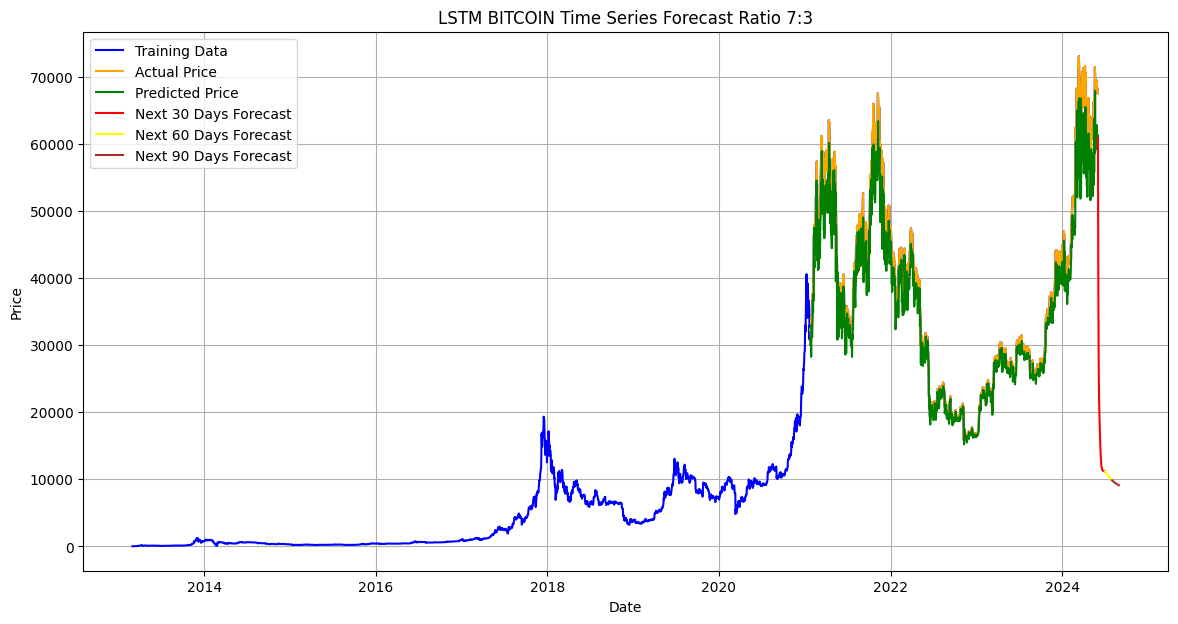

Testing MAE: 2519.3913
Testing RMSE: 3566.0182
Testing MAPE: 5.67%


In [41]:
results = process_dataset(bitcoin_df, "BITCOIN", 30, 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Streaming output truncated to the last 5000 lines.
 [0.00473354]
 [0.00548527]
 [0.00546473]
 [0.00547157]
 [0.00585634]
 [0.00676416]
 [0.01028453]
 [0.00837167]
 [0.00826624]
 [0.01000383]
 [0.01051183]
 [0.01092946]
 [0.01041598]
 [0.01089522]
 [0.01281219]
 [0.01431701]
 [0.0146114 ]
 [0.01605598]
 [0.01603954]
 [0.01328322]
 [0.01454568]
 [0.01534396]
 [0.01647634]
 [0.0146785 ]
 [0.01110061]
 [0.0090741 ]
 [0.01053922]
 [0.01211387]
 [0.01368441]
 [0.01212619]
 [0.01185371]
 [0.0123576 ]
 [0.01197557]
 [0.01212619]
 [0.00993537]
 [0.00932057]
 [0.00693805]
 [0.00955335]
 [0.00843055]
 [0.00830047]
 [0.00828678]
 [0.00929593]
 [0.00915352]
 [0.00921514]
 [0.01051183]
 [0.01052552]
 [0.00996413]
 [0.01027906]
 [0.01055017]
 [0.01056523]
 [0.01070216]
 [0.01126356]
 [0.01163873]
 [0.01219192]
 [0.01342425]
 [0.01339687]
 [0.01157849]
 [0.01238498]
 [0.01236034]
 [0.01264514]
 [0.01329554]
 [0.01239867]
 [0.01216727]
 [0.01211798]
 [0.01241784]
 [0.01203856]
 [0.01177429]
 [0.0119317

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 [0.00260023]
 [0.00261529]
 [0.00260708]
 [0.00259065]
 [0.00266048]
 [0.00267417]
 [0.00266322]
 [0.00267828]
 [0.00268649]
 [0.00271388]
 [0.00273168]
 [0.0027755 ]
 [0.00295076]
 [0.0029179 ]
 [0.00293159]
 [0.00287271]
 [0.00288504]
 [0.00287271]
 [0.00291927]
 [0.00286861]
 [0.00282479]
 [0.00285217]
 [0.00285628]
 [0.00296308]
 [0.00293844]
 [0.00304935]
 [0.00314657]
 [0.00305756]
 [0.00302059]
 [0.00302744]
 [0.00309727]
 [0.00322872]
 [0.00321503]
 [0.00317532]
 [0.00320818]
 [0.00321503]
 [0.00341357]
 [0.00352859]
 [0.00378053]
 [0.00350668]
 [0.00346013]
 [0.00341083]
 [0.00331772]
 [0.0033588 ]
 [0.00328212]
 [0.00327117]
 [0.00333279]
 [0.00329718]
 [0.00331635]
 [0.00330266]
 [0.0034793 ]
 [0.0034834 ]
 [0.00352585]
 [0.00354228]
 [0.00355187]
 [0.0034793 ]
 [0.00346013]
 [0.00341494]
 [0.00337112]
 [0.00338345]
 [0.00338619]
 [0.00342316]
 [0.00338756]
 [0.00333689]
 [0.00333552]
 [0.00307126]
 [0.00314383]
 [0.0031356

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  [2.73852558e-06]
  [2.60159930e-05]
  ...
  [7.69525687e-04]
  [7.92803155e-04]
  [8.03757257e-04]]

 [[2.73852558e-06]
  [2.60159930e-05]
  [8.21557673e-05]
  ...
  [7.92803155e-04]
  [8.03757257e-04]
  [9.54376164e-04]]

 ...

 [[9.50379286e-01]
  [9.68449447e-01]
  [9.56257531e-01]
  ...
  [9.08926224e-01]
  [8.79770512e-01]
  [8.82665133e-01]]

 [[9.68449447e-01]
  [9.56257531e-01]
  [9.52694709e-01]
  ...
  [8.79770512e-01]
  [8.82665133e-01]
  [8.72659930e-01]]

 [[9.56257531e-01]
  [9.52694709e-01]
  [9.76252875e-01]
  ...
  [8.82665133e-01]
  [8.72659930e-01]
  [8.68420692e-01]]] [[8.03757257e-04]
 [9.54376164e-04]
 [1.14607295e-03]
 ...
 [8.72659930e-01]
 [8.68420692e-01]
 [8.63667981e-01]]
[[[2.73852558e-06]
  [0.00000000e+00]
  [2.73852558e-06]
  ...
  [7.10647387e-04]
  [7.69525687e-04]
  [7.92803155e-04]]

 [[0.00000000e+00]
  [2.73852558e-06]
  [2.60159930e-05]
  ...
  [7.69525687e-04]
  [7.92803155e-04]
  [8.03757257e-

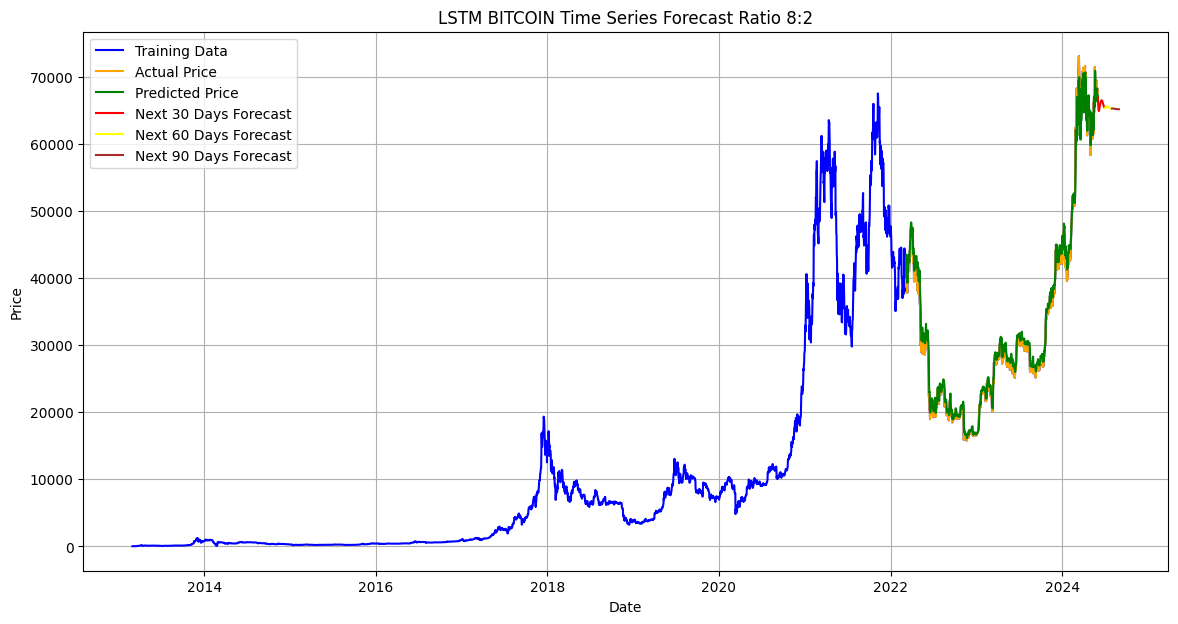

Testing MAE: 1025.7671
Testing RMSE: 1407.3538
Testing MAPE: 3.11%


In [42]:
results = process_dataset(bitcoin_df, "BITCOIN", 30, 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# NASDAQ

# RATIO 6:4

Streaming output truncated to the last 5000 lines.
 [0.07986562]
 [0.07735146]
 [0.0794881 ]
 [0.07918926]
 [0.08132301]
 [0.08093466]
 [0.08125733]
 [0.08319691]
 [0.0824166 ]
 [0.08019189]
 [0.08558186]
 [0.08601496]
 [0.08559269]
 [0.08444496]
 [0.0843172 ]
 [0.08234947]
 [0.08351451]
 [0.07897343]
 [0.07788923]
 [0.08038318]
 [0.08423491]
 [0.08237906]
 [0.08322289]
 [0.08015508]
 [0.07651702]
 [0.07708582]
 [0.07270499]
 [0.07109168]
 [0.07141867]
 [0.07453918]
 [0.07952347]
 [0.08013126]
 [0.0773363 ]
 [0.06939536]
 [0.06593198]
 [0.06833137]
 [0.07344992]
 [0.06408119]
 [0.06015583]
 [0.06181317]
 [0.06264112]
 [0.06639901]
 [0.06707032]
 [0.06894926]
 [0.07183012]
 [0.0693405 ]
 [0.07088307]
 [0.06562953]
 [0.0655458 ]
 [0.06764923]
 [0.0684447 ]
 [0.06937515]
 [0.0691189 ]
 [0.07014102]
 [0.06600489]
 [0.06506   ]
 [0.06389279]
 [0.06536317]
 [0.07055968]
 [0.06957077]
 [0.06743918]
 [0.06517694]
 [0.06671445]
 [0.06925677]
 [0.06716921]
 [0.06967038]
 [0.07131617]
 [0.0735878

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 [0.12937217]
 [0.12474736]
 [0.12141896]
 [0.12106598]
 [0.12044376]
 [0.12116415]
 [0.11794692]
 [0.12060834]
 [0.12108114]
 [0.12032754]
 [0.12586548]
 [0.11128002]
 [0.10308427]
 [0.11011714]
 [0.11642384]
 [0.12100246]
 [0.12243892]
 [0.11957539]
 [0.12219277]
 [0.12346682]
 [0.12923791]
 [0.13153913]
 [0.13400638]
 [0.13277275]
 [0.13481772]
 [0.13449506]
 [0.13638555]
 [0.13498447]
 [0.13885063]
 [0.13769352]
 [0.13958907]
 [0.13940645]
 [0.14030297]
 [0.14245116]
 [0.14354619]
 [0.1440623 ]
 [0.1456554 ]
 [0.14230102]
 [0.14388978]
 [0.1443597 ]
 [0.14832043]
 [0.1477444 ]
 [0.14863515]
 [0.14712723]
 [0.14884593]
 [0.14917075]
 [0.15127275]
 [0.14875281]
 [0.14886469]
 [0.14969408]
 [0.14956632]
 [0.1500153 ]
 [0.15113271]
 [0.14807284]
 [0.14767655]
 [0.14816162]
 [0.14912961]
 [0.14845541]
 [0.14775017]
 [0.14876003]
 [0.15039788]
 [0.15227538]
 [0.15285429]
 [0.1510894 ]
 [0.14144781]
 [0.14765417]
 [0.1435664 ]
 [0.1449025

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  [4.17005931e-03]
  [4.04301578e-03]
  ...
  [9.65819517e-03]
  [9.28211747e-03]
  [3.61857492e-03]]

 [[4.17005931e-03]
  [4.04301578e-03]
  [4.74464252e-03]
  ...
  [9.28211747e-03]
  [3.61857492e-03]
  [7.09350403e-03]]

 ...

 [[9.28929254e-01]
  [9.22608839e-01]
  [9.33016302e-01]
  ...
  [9.44320288e-01]
  [9.44712968e-01]
  [9.48515612e-01]]

 [[9.22608839e-01]
  [9.33016302e-01]
  [9.46227385e-01]
  ...
  [9.44712968e-01]
  [9.48515612e-01]
  [9.38678401e-01]]

 [[9.33016302e-01]
  [9.46227385e-01]
  [9.41360030e-01]
  ...
  [9.48515612e-01]
  [9.38678401e-01]
  [9.58300851e-01]]] [[0.00361857]
 [0.0070935 ]
 [0.00276536]
 ...
 [0.9386784 ]
 [0.95830085]
 [0.93901983]]
[[[2.43981313e-04]
  [1.13112047e-03]
  [4.17005931e-03]
  ...
  [9.44814026e-03]
  [9.65819517e-03]
  [9.28211747e-03]]

 [[1.13112047e-03]
  [4.17005931e-03]
  [4.04301578e-03]
  ...
  [9.65819517e-03]
  [9.28211747e-03]
  [3.61857492e-03]]

 [[4.17005931e-03]

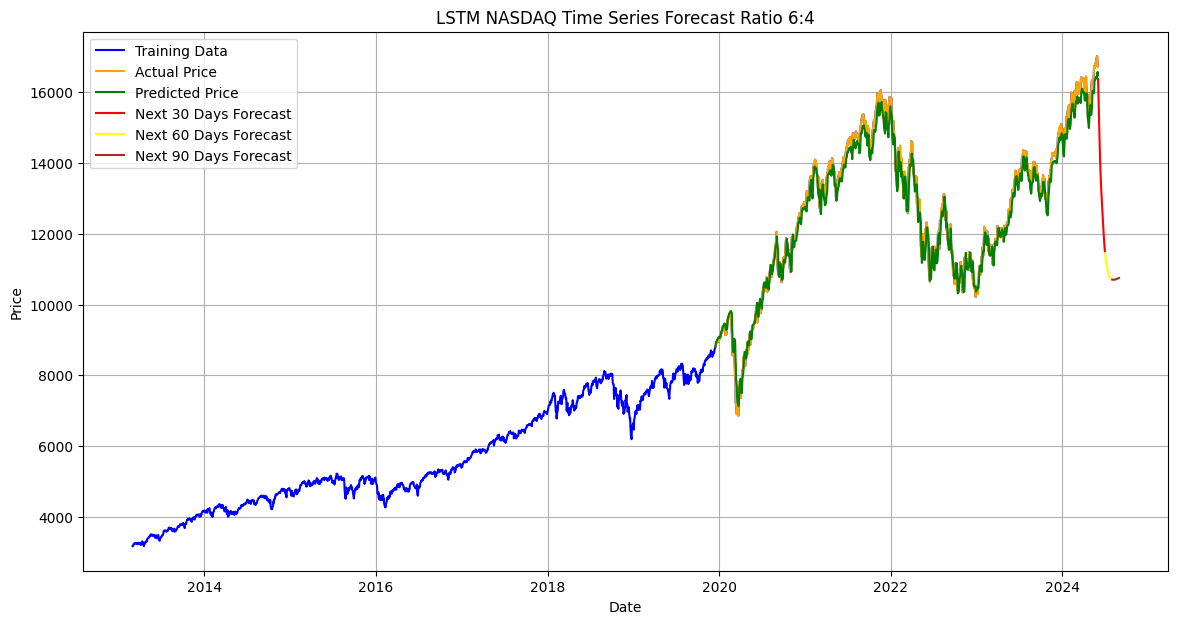

Testing MAE: 232.1079
Testing RMSE: 288.3888
Testing MAPE: 1.82%


In [43]:
results = process_dataset(nasdaq_df, "NASDAQ", 30, 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Streaming output truncated to the last 5000 lines.
  [4.17005931e-03]
  [4.04301578e-03]
  ...
  [9.65819517e-03]
  [9.28211747e-03]
  [3.61857492e-03]]

 [[4.17005931e-03]
  [4.04301578e-03]
  [4.74464252e-03]
  ...
  [9.28211747e-03]
  [3.61857492e-03]
  [7.09350403e-03]]

 ...

 [[9.28929254e-01]
  [9.22608839e-01]
  [9.33016302e-01]
  ...
  [9.44320288e-01]
  [9.44712968e-01]
  [9.48515612e-01]]

 [[9.22608839e-01]
  [9.33016302e-01]
  [9.46227385e-01]
  ...
  [9.44712968e-01]
  [9.48515612e-01]
  [9.38678401e-01]]

 [[9.33016302e-01]
  [9.46227385e-01]
  [9.41360030e-01]
  ...
  [9.48515612e-01]
  [9.38678401e-01]
  [9.58300851e-01]]] [[0.00361857]
 [0.0070935 ]
 [0.00276536]
 ...
 [0.9386784 ]
 [0.95830085]
 [0.93901983]]
[[[2.43981313e-04]
  [1.13112047e-03]
  [4.17005931e-03]
  ...
  [9.44814026e-03]
  [9.65819517e-03]
  [9.28211747e-03]]

 [[1.13112047e-03]
  [4.17005931e-03]
  [4.04301578e-03]
  ...
  [9.65819517e-03]
  [9.28211747e-03]
  [3.61857492e-03]]

 [[4.17005931e-03]

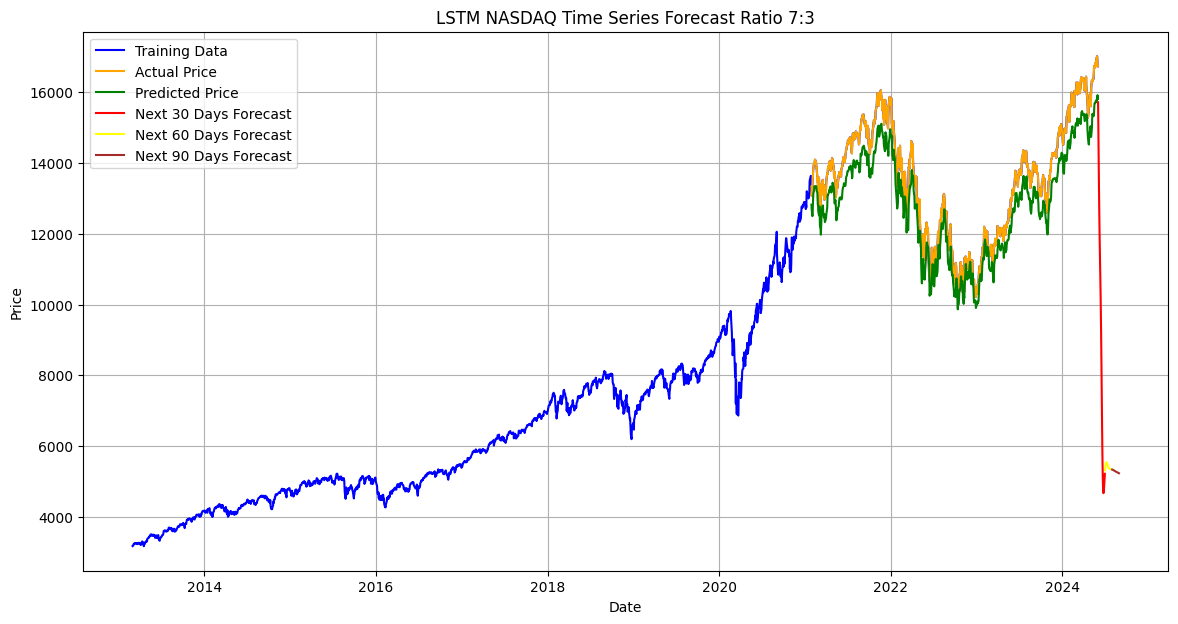

Testing MAE: 674.7544
Testing RMSE: 728.2889
Testing MAPE: 4.89%


In [44]:
results = process_dataset(nasdaq_df, "NASDAQ", 30, 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Streaming output truncated to the last 5000 lines.
 [0.10987677]
 [0.10861066]
 [0.11088012]
 [0.10895065]
 [0.11083898]
 [0.11164022]
 [0.11466616]
 [0.1149087 ]
 [0.11700709]
 [0.1173182 ]
 [0.11267822]
 [0.11473257]
 [0.11607952]
 [0.11571644]
 [0.11653356]
 [0.11364115]
 [0.11550205]
 [0.1095505 ]
 [0.11129301]
 [0.10735467]
 [0.10385808]
 [0.09971978]
 [0.10668408]
 [0.11419769]
 [0.11542337]
 [0.1165812 ]
 [0.11542626]
 [0.11600734]
 [0.11841756]
 [0.11842117]
 [0.11629391]
 [0.11330622]
 [0.11263924]
 [0.10728032]
 [0.10296156]
 [0.10712873]
 [0.11331633]
 [0.11099778]
 [0.10815663]
 [0.10792492]
 [0.10632388]
 [0.10137929]
 [0.10596729]
 [0.10744489]
 [0.10835225]
 [0.11434206]
 [0.11488199]
 [0.11588391]
 [0.10936859]
 [0.10622788]
 [0.10950646]
 [0.10602937]
 [0.10902139]
 [0.11270637]
 [0.11190946]
 [0.11540316]
 [0.11390896]
 [0.1125815 ]
 [0.11703091]
 [0.11800755]
 [0.12208089]
 [0.12469611]
 [0.12508806]
 [0.12559985]
 [0.1269237 ]
 [0.12918089]
 [0.12954181]
 [0.1300579

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 [0.14678291]
 [0.14996044]
 [0.15014596]
 [0.14981535]
 [0.15093926]
 [0.15472385]
 [0.15281604]
 [0.15042459]
 [0.14794868]
 [0.14608128]
 [0.14601199]
 [0.14344513]
 [0.13997959]
 [0.1365754 ]
 [0.1357063 ]
 [0.14435393]
 [0.14632599]
 [0.15048233]
 [0.14743112]
 [0.14947465]
 [0.14812409]
 [0.15225445]
 [0.15362305]
 [0.15646637]
 [0.15556696]
 [0.15898486]
 [0.16024736]
 [0.15983808]
 [0.16115471]
 [0.15898126]
 [0.15978322]
 [0.1557236 ]
 [0.15048522]
 [0.15081293]
 [0.154656  ]
 [0.15639635]
 [0.16078224]
 [0.16248578]
 [0.16444485]
 [0.16213785]
 [0.16584016]
 [0.16387965]
 [0.16533632]
 [0.16391502]
 [0.16537891]]
[[[0.00024398]
  [0.00113112]
  [0.00417006]
  ...
  [0.00944814]
  [0.0096582 ]
  [0.00928212]]

 [[0.00113112]
  [0.00417006]
  [0.00404302]
  ...
  [0.0096582 ]
  [0.00928212]
  [0.00361857]]

 [[0.00417006]
  [0.00404302]
  [0.00474464]
  ...
  [0.00928212]
  [0.00361857]
  [0.0070935 ]]

 ...

 [[0.1365754 ]
  [

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  [4.17005931e-03]
  [4.04301578e-03]
  ...
  [9.65819517e-03]
  [9.28211747e-03]
  [3.61857492e-03]]

 [[4.17005931e-03]
  [4.04301578e-03]
  [4.74464252e-03]
  ...
  [9.28211747e-03]
  [3.61857492e-03]
  [7.09350403e-03]]

 ...

 [[9.28929254e-01]
  [9.22608839e-01]
  [9.33016302e-01]
  ...
  [9.44320288e-01]
  [9.44712968e-01]
  [9.48515612e-01]]

 [[9.22608839e-01]
  [9.33016302e-01]
  [9.46227385e-01]
  ...
  [9.44712968e-01]
  [9.48515612e-01]
  [9.38678401e-01]]

 [[9.33016302e-01]
  [9.46227385e-01]
  [9.41360030e-01]
  ...
  [9.48515612e-01]
  [9.38678401e-01]
  [9.58300851e-01]]] [[0.00361857]
 [0.0070935 ]
 [0.00276536]
 ...
 [0.9386784 ]
 [0.95830085]
 [0.93901983]]
[[[2.43981313e-04]
  [1.13112047e-03]
  [4.17005931e-03]
  ...
  [9.44814026e-03]
  [9.65819517e-03]
  [9.28211747e-03]]

 [[1.13112047e-03]
  [4.17005931e-03]
  [4.04301578e-03]
  ...
  [9.65819517e-03]
  [9.28211747e-03]
  [3.61857492e-03]]

 [[4.17005931e-03]

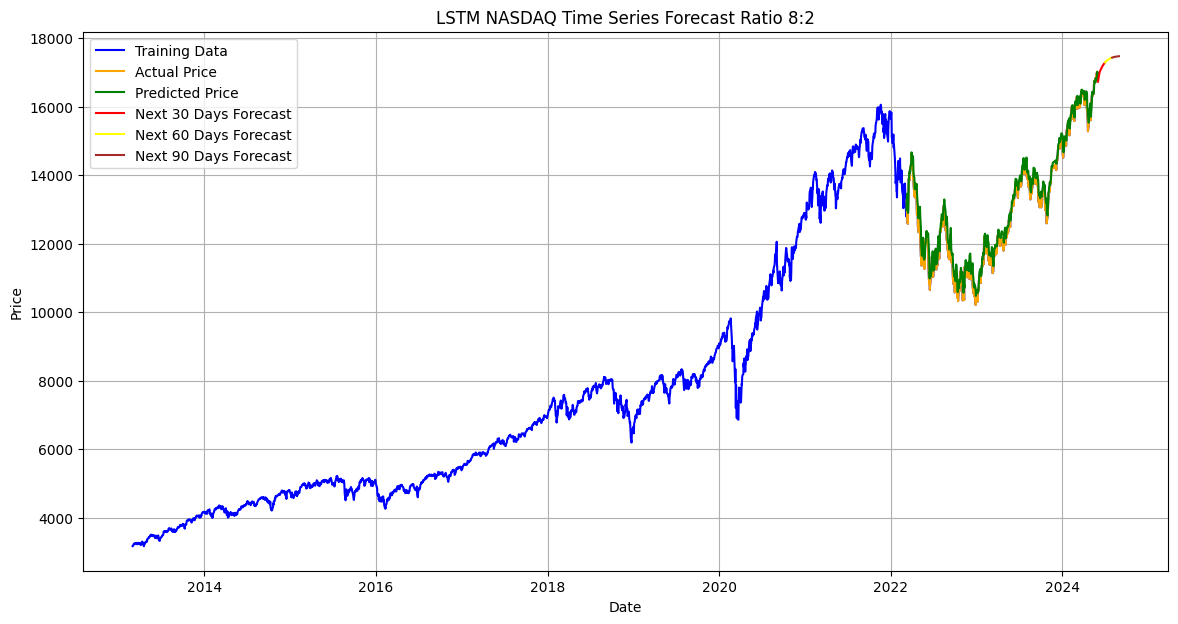

Testing MAE: 206.4863
Testing RMSE: 264.1253
Testing MAPE: 1.65%


In [45]:
results = process_dataset(nasdaq_df, "NASDAQ", 30, 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# US Dollar

# RATIO 6:4

Streaming output truncated to the last 5000 lines.
 [0.02150568]
 [0.01981616]
 [0.01821254]
 [0.02162023]
 [0.01162624]
 [0.01297214]
 [0.01251396]
 [0.01156897]
 [0.        ]
 [0.00335042]
 [0.00790355]
 [0.02391111]
 [0.02402566]
 [0.0311274 ]
 [0.02889379]
 [0.02686063]
 [0.02809198]
 [0.02640245]
 [0.02769107]
 [0.02932333]
 [0.03376192]
 [0.03791415]
 [0.03791415]
 [0.03662553]
 [0.04278228]
 [0.04049139]
 [0.03659689]
 [0.0447868 ]
 [0.04200911]
 [0.04524498]
 [0.03656825]
 [0.03725552]
 [0.04455772]
 [0.04925403]
 [0.0481945 ]
 [0.0419232 ]
 [0.04381318]
 [0.0384296 ]
 [0.04553134]
 [0.04421408]
 [0.0363678 ]
 [0.03765642]
 [0.03470691]
 [0.03628189]
 [0.03261648]
 [0.03301738]
 [0.02749062]
 [0.0196157 ]
 [0.02058933]
 [0.02459838]
 [0.03307465]
 [0.03307465]
 [0.03267375]
 [0.03135649]
 [0.02623063]
 [0.02989605]
 [0.03158558]
 [0.03161421]
 [0.0377996 ]
 [0.04292546]
 [0.04135048]
 [0.04206638]
 [0.04298273]
 [0.04979812]
 [0.05122992]
 [0.05257581]
 [0.05724349]
 [0.0571575

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  [0.08650955]
  [0.09681853]
  ...
  [0.09160677]
  [0.09392629]
  [0.09681853]]

 [[0.08650955]
  [0.09681853]
  [0.08582228]
  ...
  [0.09392629]
  [0.09681853]
  [0.07723147]]

 ...

 [[0.7095444 ]
  [0.7150998 ]
  [0.70653761]
  ...
  [0.70948713]
  [0.71005985]
  [0.74181724]]

 [[0.7150998 ]
  [0.70653761]
  [0.70593626]
  ...
  [0.71005985]
  [0.74181724]
  [0.74276223]]

 [[0.70653761]
  [0.70593626]
  [0.70522035]
  ...
  [0.74181724]
  [0.74276223]
  [0.76475473]]] [[0.09681853]
 [0.07723147]
 [0.10495118]
 ...
 [0.74276223]
 [0.76475473]
 [0.76950832]]
[[[0.09255176]
  [0.08960225]
  [0.08650955]
  ...
  [0.10045531]
  [0.09160677]
  [0.09392629]]

 [[0.08960225]
  [0.08650955]
  [0.09681853]
  ...
  [0.09160677]
  [0.09392629]
  [0.09681853]]

 [[0.08650955]
  [0.09681853]
  [0.08582228]
  ...
  [0.09392629]
  [0.09681853]
  [0.07723147]]

 ...

 [[0.7150998 ]
  [0.70653761]
  [0.70593626]
  ...
  [0.71005985]
  [0.7418172

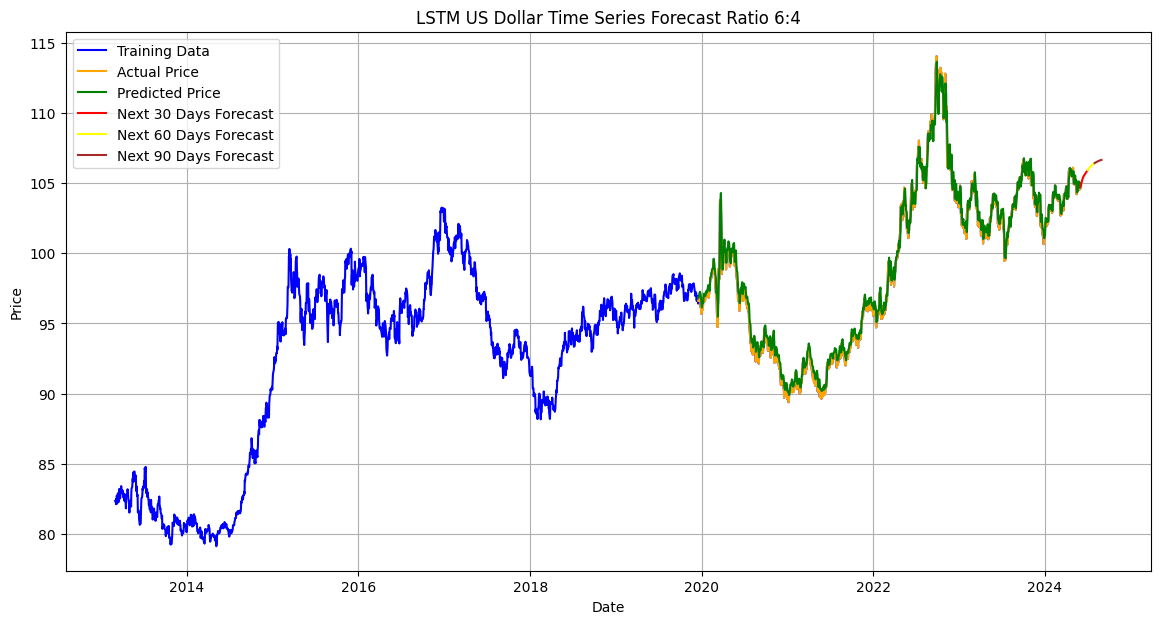

Testing MAE: 0.4405
Testing RMSE: 0.5704
Testing MAPE: 0.44%


In [46]:
results = process_dataset(usd_df, "US Dollar", 30, 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Streaming output truncated to the last 5000 lines.
 [0.22811489]
 [0.24171702]
 [0.25795367]
 [0.24627015]
 [0.25156782]
 [0.2460697 ]
 [0.25142464]
 [0.24701469]
 [0.24246156]
 [0.25440279]
 [0.24395063]
 [0.24584061]
 [0.24458062]
 [0.26571404]
 [0.26001546]
 [0.25302826]
 [0.24406518]
 [0.24406518]
 [0.26594313]
 [0.25360099]
 [0.27424759]
 [0.28255205]
 [0.27516394]
 [0.29306148]
 [0.28409839]
 [0.27393259]
 [0.26233498]
 [0.27364623]
 [0.26399588]
 [0.27043899]
 [0.26262135]
 [0.29208786]
 [0.2964119 ]
 [0.30683543]
 [0.30992812]
 [0.32072392]
 [0.31777441]
 [0.32026574]
 [0.32559205]
 [0.31937802]
 [0.3299161 ]
 [0.35099224]
 [0.35783626]
 [0.36115804]
 [0.37195384]
 [0.3858996 ]
 [0.37287019]
 [0.37392973]
 [0.383036  ]
 [0.37854013]
 [0.38607142]
 [0.39414679]
 [0.39414679]
 [0.40729074]
 [0.4013058 ]
 [0.43629908]
 [0.4560866 ]
 [0.45786203]
 [0.43309184]
 [0.44675124]
 [0.45488388]
 [0.45451161]
 [0.44695169]
 [0.41802927]
 [0.43065777]
 [0.41825835]
 [0.45030211]
 [0.4425990

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 [0.08817044]
 [0.10142894]
 [0.08708227]
 [0.07645829]
 [0.07711692]
 [0.06861201]
 [0.06772429]
 [0.06649294]
 [0.05572578]
 [0.06211162]
 [0.03553736]
 [0.03877323]
 [0.04074912]
 [0.04137911]
 [0.0447868 ]
 [0.0377137 ]
 [0.04329773]
 [0.03582372]
 [0.03427737]
 [0.03218694]
 [0.02471292]
 [0.02061797]
 [0.03132785]
 [0.02577246]
 [0.02880788]
 [0.03837233]
 [0.03983277]
 [0.03797142]
 [0.03393374]
 [0.04109275]
 [0.04115002]
 [0.01695255]
 [0.01721027]
 [0.01789754]
 [0.00469631]
 [0.00581312]
 [0.00340769]
 [0.00343633]
 [0.00515449]
 [0.01557802]
 [0.02036024]
 [0.03255921]
 [0.04822313]
 [0.043355  ]
 [0.0475645 ]
 [0.04103548]
 [0.04948312]
 [0.06474614]
 [0.0593912 ]
 [0.06088027]
 [0.05317717]
 [0.05612669]
 [0.05074311]
 [0.04868131]
 [0.04633315]
 [0.05858939]
 [0.0570144 ]
 [0.04627588]
 [0.05260445]
 [0.04329773]
 [0.04641906]
 [0.04641906]
 [0.04384181]
 [0.05200309]
 [0.04272501]
 [0.04301137]
 [0.03192921]
 [0.0340482

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  [0.08650955]
  [0.09681853]
  ...
  [0.09160677]
  [0.09392629]
  [0.09681853]]

 [[0.08650955]
  [0.09681853]
  [0.08582228]
  ...
  [0.09392629]
  [0.09681853]
  [0.07723147]]

 ...

 [[0.7095444 ]
  [0.7150998 ]
  [0.70653761]
  ...
  [0.70948713]
  [0.71005985]
  [0.74181724]]

 [[0.7150998 ]
  [0.70653761]
  [0.70593626]
  ...
  [0.71005985]
  [0.74181724]
  [0.74276223]]

 [[0.70653761]
  [0.70593626]
  [0.70522035]
  ...
  [0.74181724]
  [0.74276223]
  [0.76475473]]] [[0.09681853]
 [0.07723147]
 [0.10495118]
 ...
 [0.74276223]
 [0.76475473]
 [0.76950832]]
[[[0.09255176]
  [0.08960225]
  [0.08650955]
  ...
  [0.10045531]
  [0.09160677]
  [0.09392629]]

 [[0.08960225]
  [0.08650955]
  [0.09681853]
  ...
  [0.09160677]
  [0.09392629]
  [0.09681853]]

 [[0.08650955]
  [0.09681853]
  [0.08582228]
  ...
  [0.09392629]
  [0.09681853]
  [0.07723147]]

 ...

 [[0.7150998 ]
  [0.70653761]
  [0.70593626]
  ...
  [0.71005985]
  [0.7418172

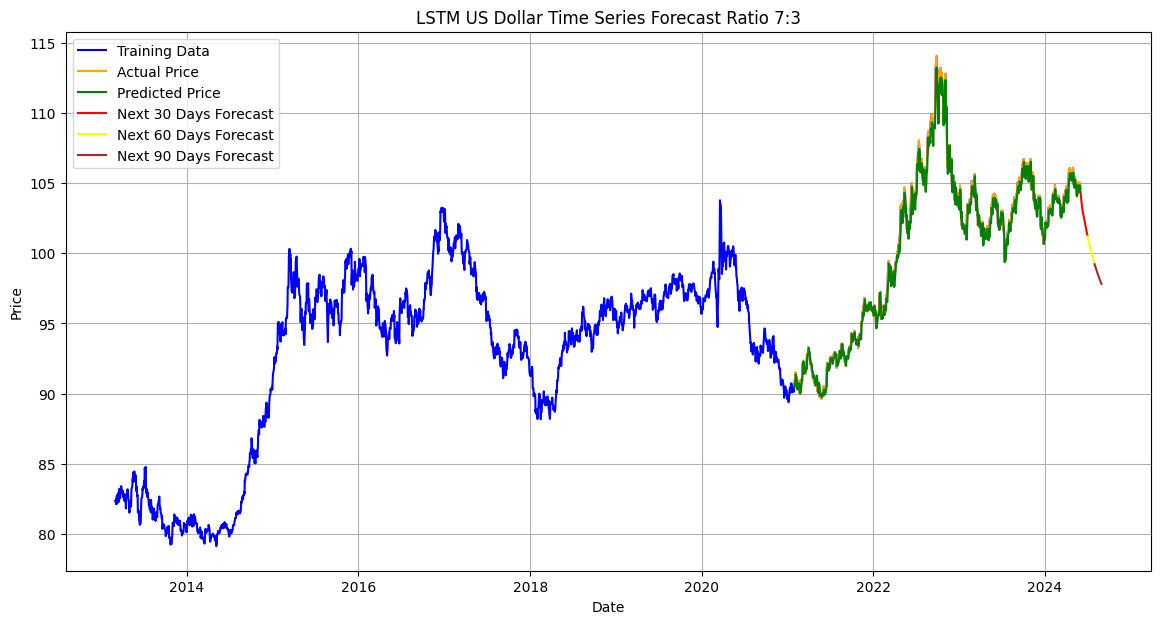

Testing MAE: 0.3905
Testing RMSE: 0.5221
Testing MAPE: 0.38%


In [47]:
results = process_dataset(usd_df, "US Dollar", 30, 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Streaming output truncated to the last 5000 lines.
 [0.01136852]
 [0.01944389]
 [0.02182068]
 [0.0216775 ]
 [0.02225022]
 [0.025887  ]
 [0.02488474]
 [0.02316658]
 [0.02150568]
 [0.01981616]
 [0.01821254]
 [0.02162023]
 [0.01162624]
 [0.01297214]
 [0.01251396]
 [0.01156897]
 [0.        ]
 [0.00335042]
 [0.00790355]
 [0.02391111]
 [0.02402566]
 [0.0311274 ]
 [0.02889379]
 [0.02686063]
 [0.02809198]
 [0.02640245]
 [0.02769107]
 [0.02932333]
 [0.03376192]
 [0.03791415]
 [0.03791415]
 [0.03662553]
 [0.04278228]
 [0.04049139]
 [0.03659689]
 [0.0447868 ]
 [0.04200911]
 [0.04524498]
 [0.03656825]
 [0.03725552]
 [0.04455772]
 [0.04925403]
 [0.0481945 ]
 [0.0419232 ]
 [0.04381318]
 [0.0384296 ]
 [0.04553134]
 [0.04421408]
 [0.0363678 ]
 [0.03765642]
 [0.03470691]
 [0.03628189]
 [0.03261648]
 [0.03301738]
 [0.02749062]
 [0.0196157 ]
 [0.02058933]
 [0.02459838]
 [0.03307465]
 [0.03307465]
 [0.03267375]
 [0.03135649]
 [0.02623063]
 [0.02989605]
 [0.03158558]
 [0.03161421]
 [0.0377996 ]
 [0.0429254

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 [0.57106039]
 [0.57621489]
 [0.57240629]
 [0.57240629]
 [0.57286447]
 [0.57681624]
 [0.57549898]
 [0.59047565]
 [0.58360299]
 [0.57569944]
 [0.57051631]
 [0.5589187 ]
 [0.59021792]
 [0.57277856]
 [0.56885542]
 [0.52346725]
 [0.50010023]
 [0.51610779]
 [0.50256293]
 [0.48861716]
 [0.48394949]
 [0.47501503]
 [0.48569629]
 [0.48569629]
 [0.51126829]
 [0.50906331]
 [0.51384554]
 [0.50393746]
 [0.52638813]
 [0.52916583]
 [0.52885083]
 [0.5235818 ]
 [0.54886744]
 [0.55004152]
 [0.55407921]
 [0.5497838 ]
 [0.53148535]
 [0.52438361]
 [0.51596461]
 [0.51945821]
 [0.51811231]
 [0.48664128]
 [0.48970533]
 [0.50224793]
 [0.50390882]
 [0.48263223]
 [0.45030211]
 [0.45929383]
 [0.46427651]
 [0.47444231]
 [0.48655537]
 [0.4896767 ]
 [0.48349131]
 [0.46075427]
 [0.45181982]
 [0.44486126]
 [0.44563443]
 [0.44279946]
 [0.4463217 ]
 [0.44093812]
 [0.44302855]
 [0.4362418 ]
 [0.42736462]
 [0.42765098]
 [0.45041665]
 [0.45508433]
 [0.44881304]
 [0.4423412

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  [0.08650955]
  [0.09681853]
  ...
  [0.09160677]
  [0.09392629]
  [0.09681853]]

 [[0.08650955]
  [0.09681853]
  [0.08582228]
  ...
  [0.09392629]
  [0.09681853]
  [0.07723147]]

 ...

 [[0.7095444 ]
  [0.7150998 ]
  [0.70653761]
  ...
  [0.70948713]
  [0.71005985]
  [0.74181724]]

 [[0.7150998 ]
  [0.70653761]
  [0.70593626]
  ...
  [0.71005985]
  [0.74181724]
  [0.74276223]]

 [[0.70653761]
  [0.70593626]
  [0.70522035]
  ...
  [0.74181724]
  [0.74276223]
  [0.76475473]]] [[0.09681853]
 [0.07723147]
 [0.10495118]
 ...
 [0.74276223]
 [0.76475473]
 [0.76950832]]
[[[0.09255176]
  [0.08960225]
  [0.08650955]
  ...
  [0.10045531]
  [0.09160677]
  [0.09392629]]

 [[0.08960225]
  [0.08650955]
  [0.09681853]
  ...
  [0.09160677]
  [0.09392629]
  [0.09681853]]

 [[0.08650955]
  [0.09681853]
  [0.08582228]
  ...
  [0.09392629]
  [0.09681853]
  [0.07723147]]

 ...

 [[0.7150998 ]
  [0.70653761]
  [0.70593626]
  ...
  [0.71005985]
  [0.7418172

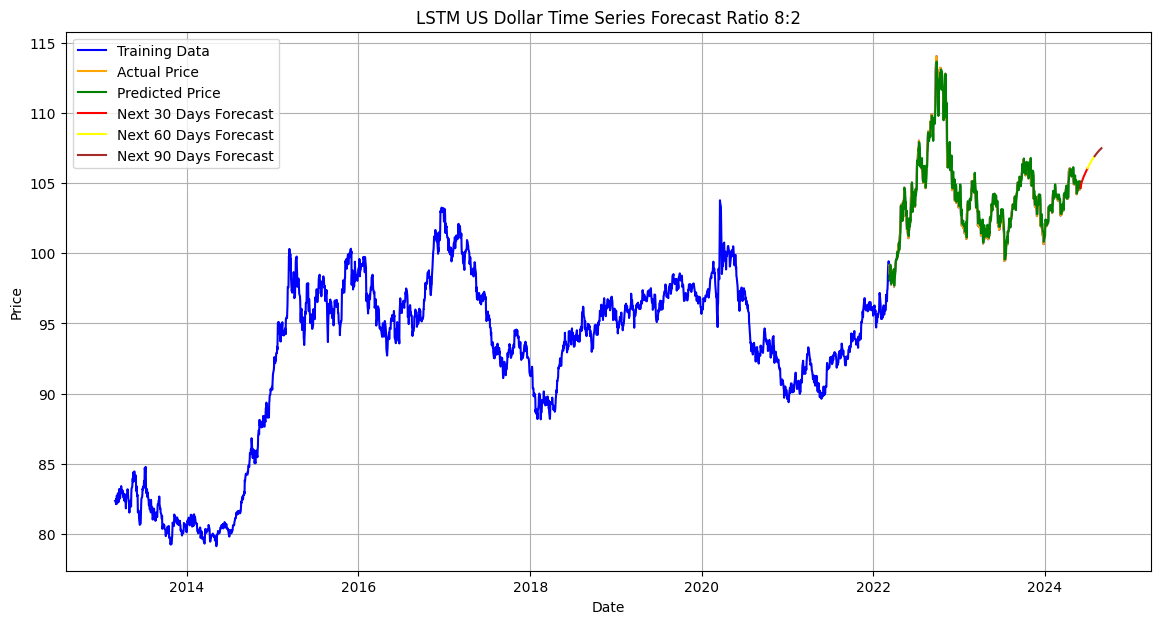

Testing MAE: 0.3962
Testing RMSE: 0.5336
Testing MAPE: 0.38%


In [48]:
results = process_dataset(usd_df, "US Dollar", 30, 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')